In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import tqdm

In [4]:
## ONLY LOAD EVERY 10TH ROW JUST FOR DEBUGGING

# Load data
df = pd.read_csv("filtered_data.csv")#, skiprows=lambda i: i % 10 != 0)

print(df.shape)
df

(18576812, 6)


station_id  year  month element  day  value
0         AGM00060490  1957      1    TMAX    1    178
1         AGM00060490  1957      1    TMAX    2    150
2         AGM00060490  1957      1    TMAX    3    161
3         AGM00060490  1957      1    TMAX    4    172
4         AGM00060490  1957      1    TMAX    5    172
...               ...   ...    ...     ...  ...    ...
18576807  ZA000067753  1990     11    PRCP   26      0
18576808  ZA000067753  1990     11    PRCP   27      0
18576809  ZA000067753  1990     11    PRCP   28      0
18576810  ZA000067753  1990     11    PRCP   29      0
18576811  ZA000067753  1990     11    PRCP   30    660

[18576812 rows x 6 columns]

In [5]:
# For each station and for each day, compute the midpoint temperature by
# averaging the min and max temperatures
data_TEMP = df.where(np.logical_or(df["element"] == "TMIN", df["element"] == "TMAX"))
data_TEMP = data_TEMP.groupby(by=["station_id", "year", "month", "day"])
data_TEMP = data_TEMP.mean().reset_index()

data_TEMP["value"] /= 10
data_TEMP.rename(columns={"value": "TEMP"}, inplace=True)
data_TEMP[["year", "month", "day"]] = data_TEMP[["year", "month", "day"]].astype(int)
data_TEMP.set_index(keys=["station_id", "year", "month", "day"], inplace=True)

print(data_TEMP.shape)
data_TEMP.head()

(3754308, 2)


Unnamed: 0  TEMP
station_id  year month day                  
AGM00060490 1957 1     1           0.0  17.8
                       2           1.0  15.0
                       3           2.0  16.1
                       4          18.5   9.7
                       5          19.5   9.7

In [6]:
# Function that gets daily data for a specific metric, and joins it with the daily
# temperature data, so that we can compute correlation more easily
def get_temp_and_metric(metric):
    data_metric = df[df["element"] == metric]
    data_metric.drop(columns=["element"], inplace=True)
    data_metric.rename(columns={"value": metric}, inplace=True)
    data_metric.set_index(keys=["station_id", "year", "month", "day"], inplace=True)

    return data_TEMP.join(data_metric, how="inner")

In [5]:
# Function that, for each metric, computes correlation between temperature and *metric* for each (station, year) pair
def compute_correlations(metric_names):
    # Get data for each of the above metrics
    metric_name_to_df = {metric: get_temp_and_metric(metric) for metric in metric_names}
    print([x.shape for x in metric_name_to_df.values()])
    
    heatmaps = {}
    for metric in metric_names:
        metric_data = metric_name_to_df[metric]
        groupby = metric_data.groupby(by=["station_id", "year"])
        correlation_matrices = groupby.corr()
        correlations = correlation_matrices[metric].groupby(["station_id", "year"]).first()

        # Convert the pandas series into a 2D table, with station id as index and year as column
        correlation_heatmap = correlations.unstack(level=-1)

        print(f"TEMP vs. {metric}: {correlation_heatmap.shape}")

        # Get all distinct stations and distinct years so we can plot them on the graph
        stations = np.sort(metric_data.index.map(lambda pair: pair[0]).unique())
        years = np.sort(metric_data.index.map(lambda pair: pair[1]).unique())
        
        heatmaps[metric] = correlation_heatmap, stations, years

    return heatmaps

In [6]:
metric_names = ["PRCP", "SNOW", "WT01", "WT02", "WT03", "WT04", \
                "WT05", "WT06", "WT07", "WT08", "WT09", "WT10", \
                "WT11", "WT12", "WT13", "WT14", "WT15", "WT16", "WT17", "WT18"]
heatmaps = compute_correlations(metric_names)

/tmp/ipykernel_17782/3260766738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric.drop(columns=["element"], inplace=True)
/tmp/ipykernel_17782/3260766738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric.rename(columns={"value": metric}, inplace=True)
/tmp/ipykernel_17782/3260766738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric.drop(columns=["element"], inplace=True)
/tmp/ipykernel_17782/32

[(3433075, 2), (1530421, 2), (73111, 2), (7162, 2), (28184, 2), (3477, 2), (2988, 2), (3784, 2), (1038, 2), (24719, 2), (5692, 2), (8, 2), (5063, 2), (0, 2), (7899, 2), (3668, 2), (152, 2), (38176, 2), (207, 2), (20898, 2)]
TEMP vs. PRCP: (324, 145)
TEMP vs. SNOW: (181, 145)
TEMP vs. WT01: (100, 126)
TEMP vs. WT02: (8, 57)
TEMP vs. WT03: (107, 129)
TEMP vs. WT04: (87, 127)
TEMP vs. WT05: (91, 127)
TEMP vs. WT06: (74, 97)
TEMP vs. WT07: (28, 74)
TEMP vs. WT08: (54, 119)
TEMP vs. WT09: (40, 101)
TEMP vs. WT10: (7, 7)
TEMP vs. WT11: (77, 112)
TEMP vs. WT12: (0, 0)
TEMP vs. WT13: (3, 18)
TEMP vs. WT14: (45, 101)
TEMP vs. WT15: (2, 22)
TEMP vs. WT16: (37, 113)
TEMP vs. WT17: (2, 26)
TEMP vs. WT18: (28, 111)


In [7]:
# A pandas series mapping station ID's to names
station_names = pd.read_fwf("ghcnd-stations.txt", header=None, usecols=[0, 4])
station_names.rename(columns={0: "station_id", 4: "station_name"}, inplace=True)
station_names = station_names.set_index(keys="station_id").squeeze()

In [8]:
# Plot a heatmap of correlations between temperature and precipitation, for each station and each year
def plot_heatmap(metric, year_tick_frequency=29, station_tick_frequency=7):
    array, stations, years = heatmaps[metric]
    
    print(f"Heatmap for {metric} has shape {array.shape}")

    plt.figure(figsize=(40, 10))
    plt.imshow(array, cmap="seismic")
    plt.colorbar()
    
    plt.xticks(ticks=np.arange(len(years))[::year_tick_frequency], labels=years[::year_tick_frequency])
    plt.yticks(ticks=np.arange(len(stations))[::station_tick_frequency], labels=station_names[stations[::station_tick_frequency]])
    #plt.xlim(0, len(years))
    #plt.ylim(0, len(stations))
    plt.grid()
    plt.show()

Heatmap for PRCP has shape (324, 145)


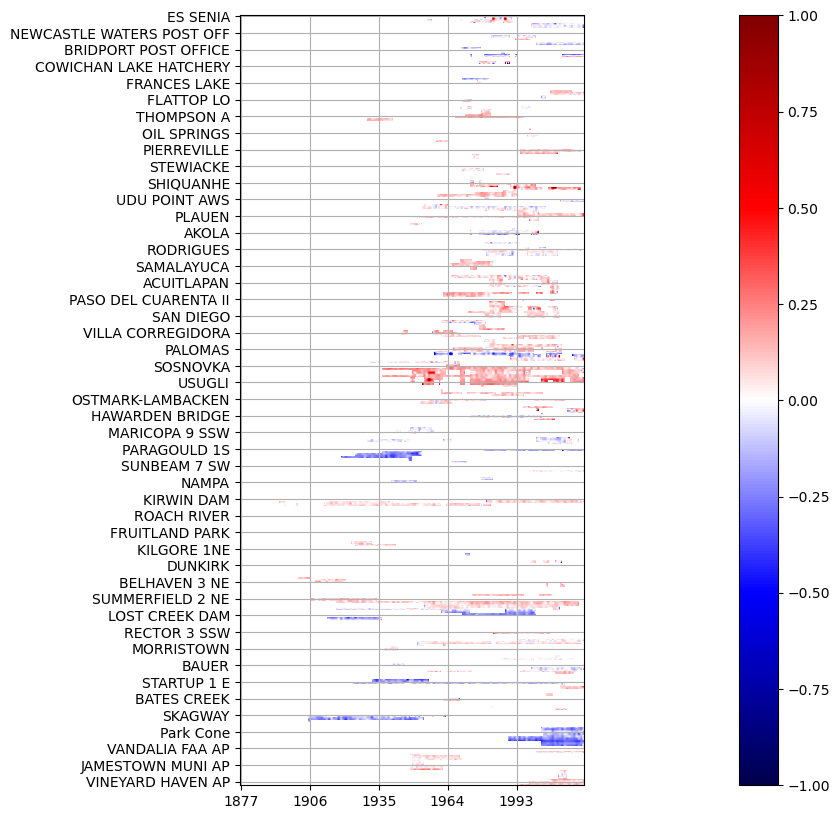

Heatmap for SNOW has shape (181, 145)


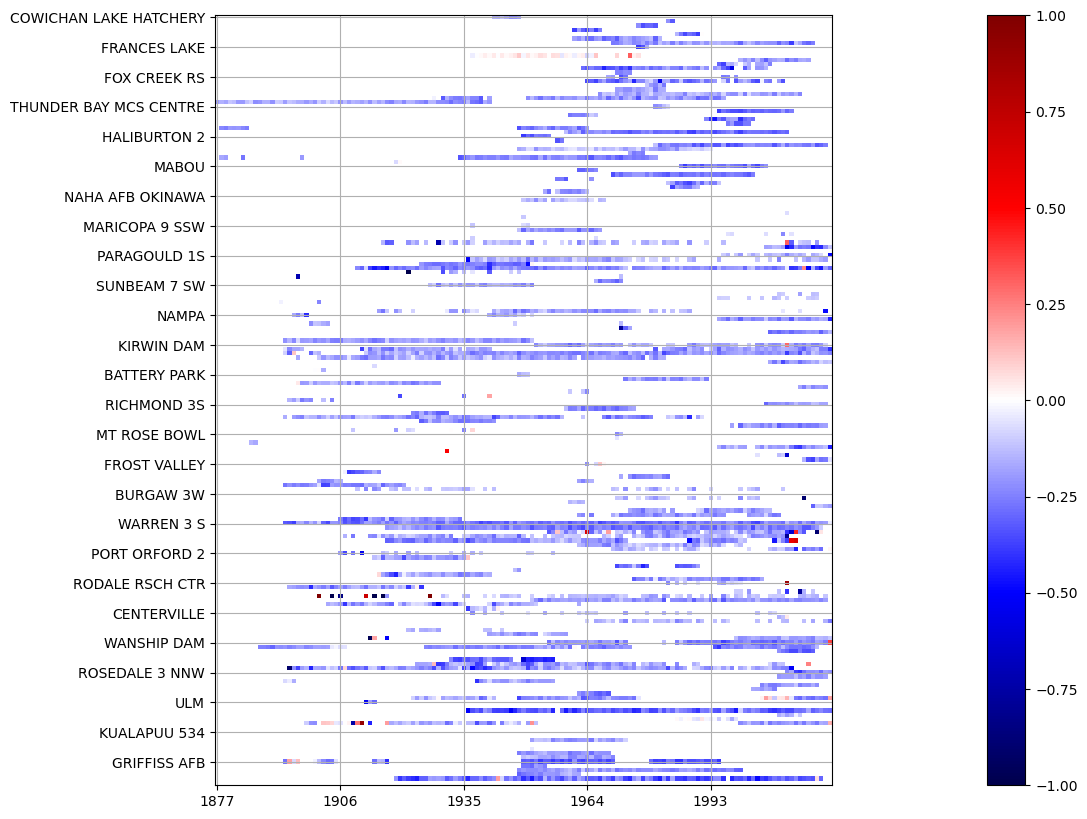

Heatmap for WT01 has shape (100, 126)


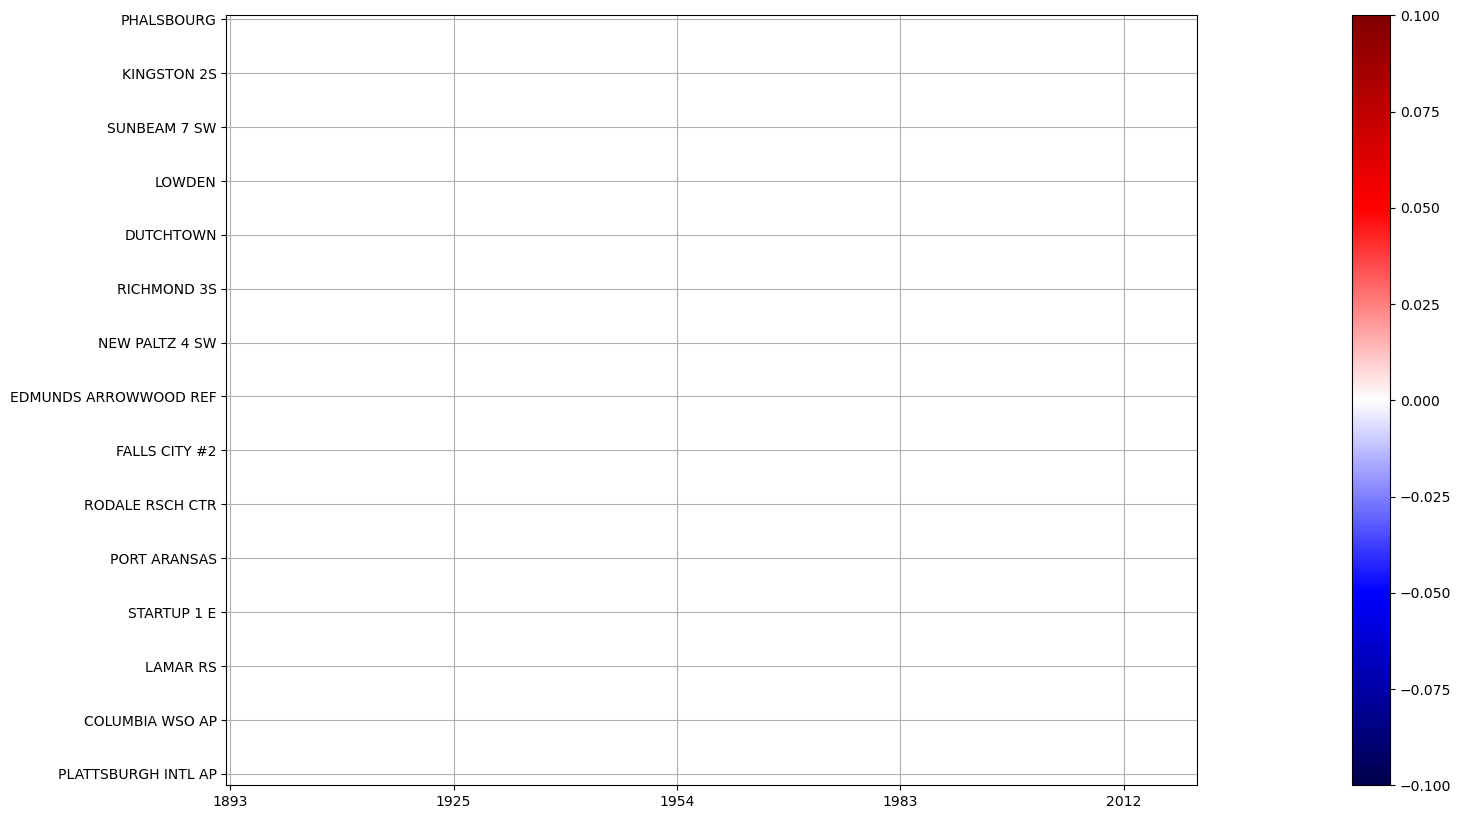

Heatmap for WT02 has shape (8, 57)


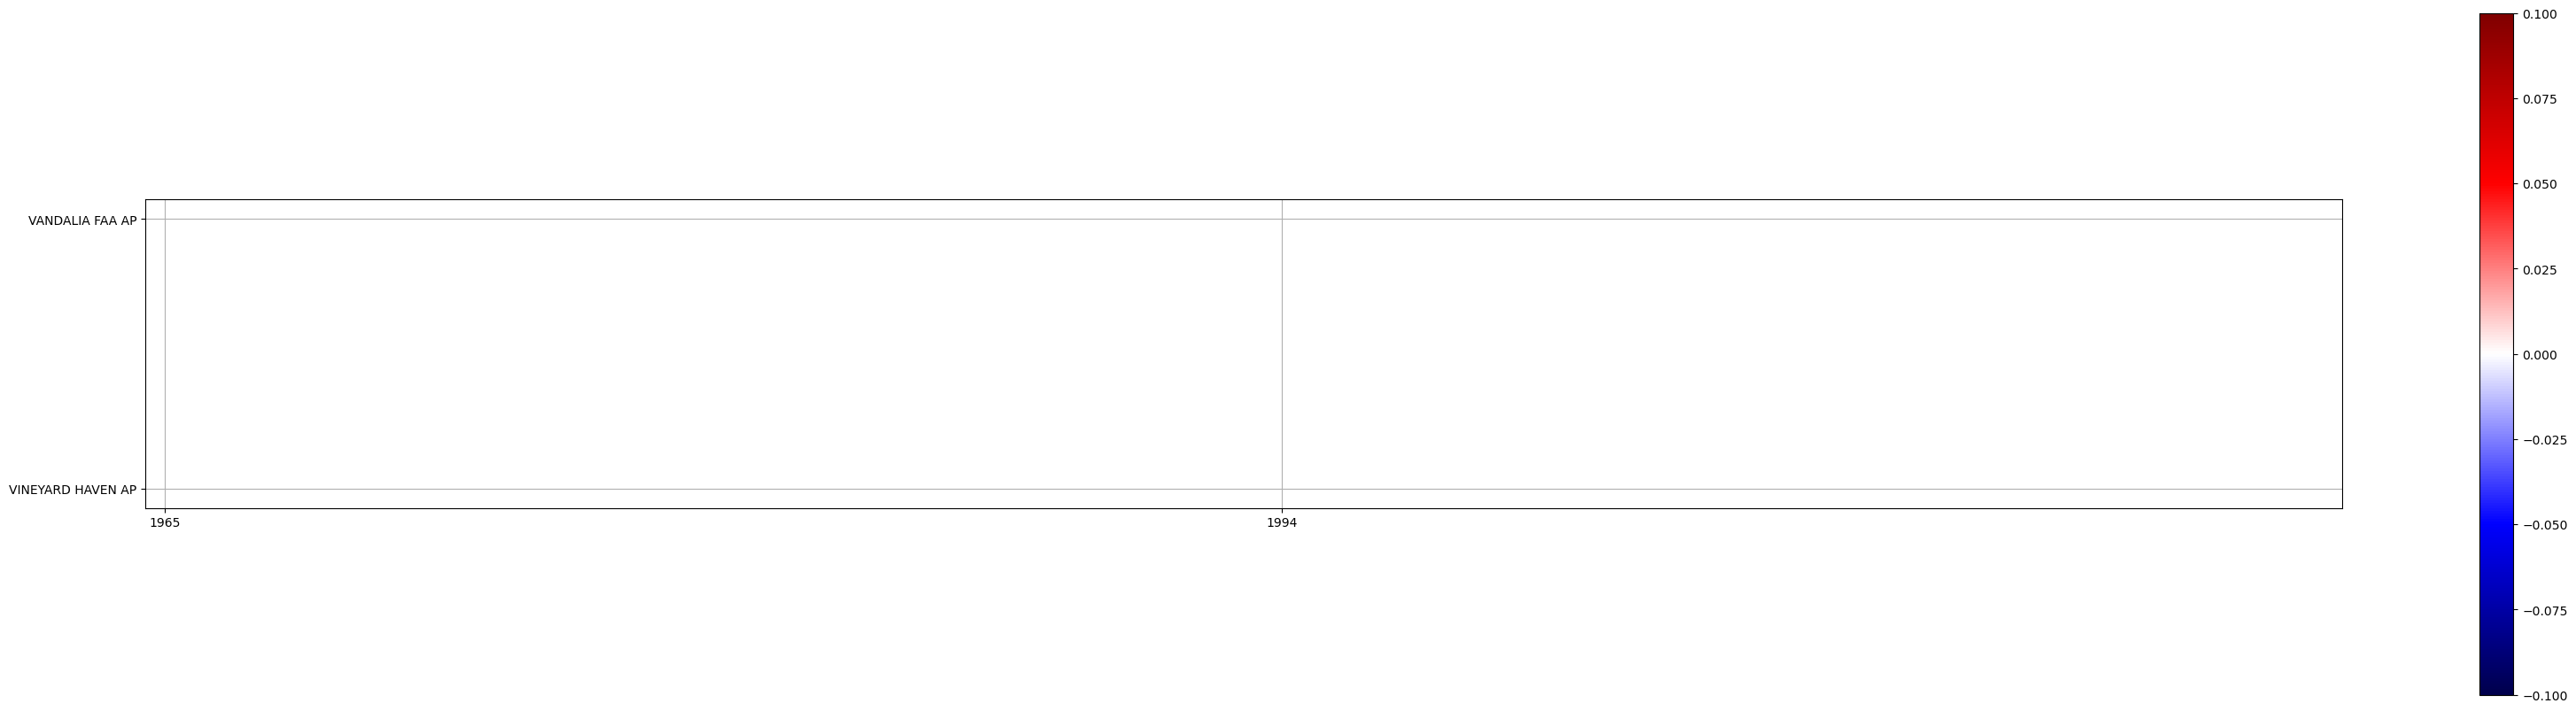

Heatmap for WT03 has shape (107, 129)


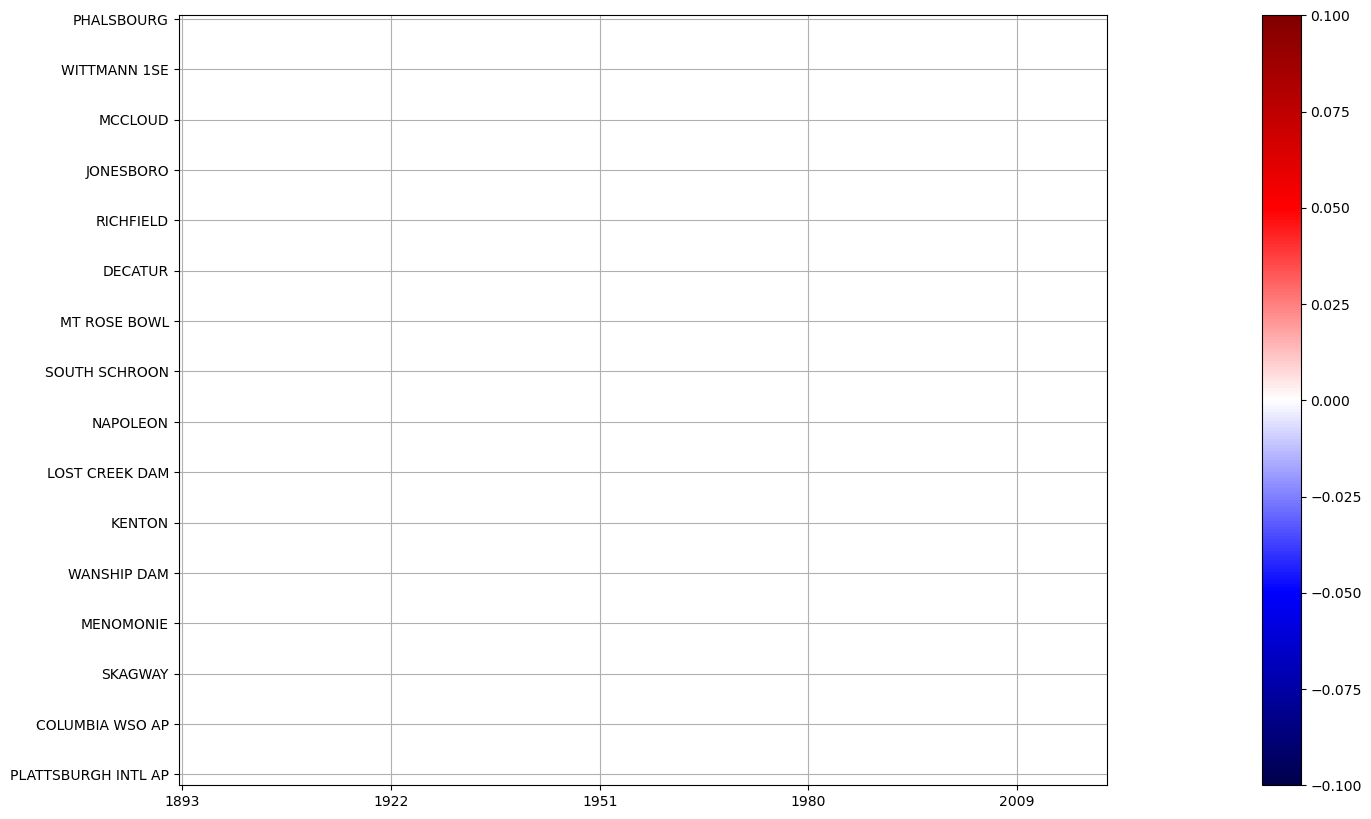

Heatmap for WT04 has shape (87, 127)


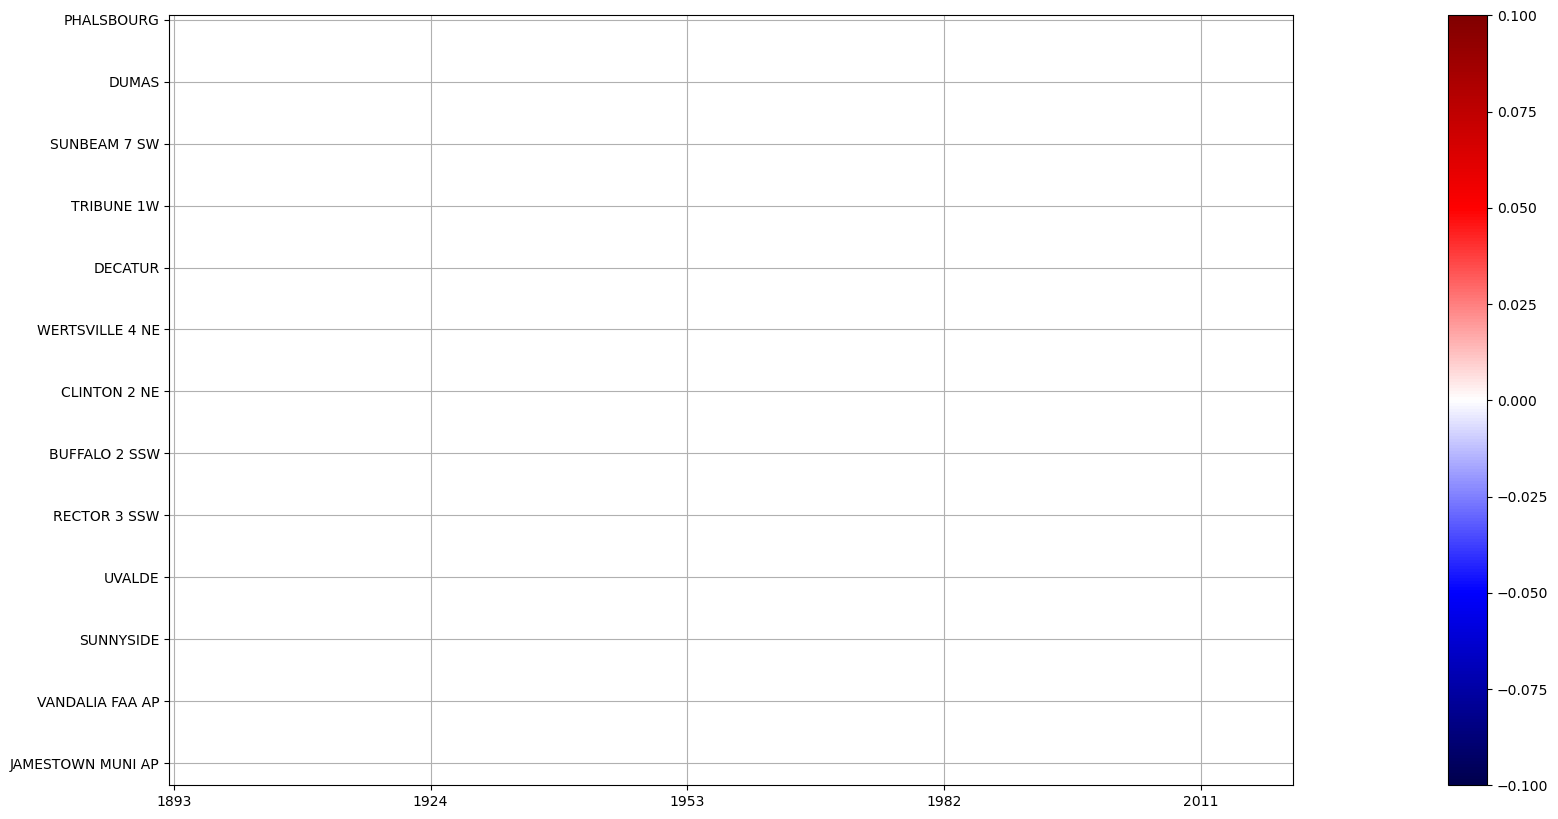

Heatmap for WT05 has shape (91, 127)


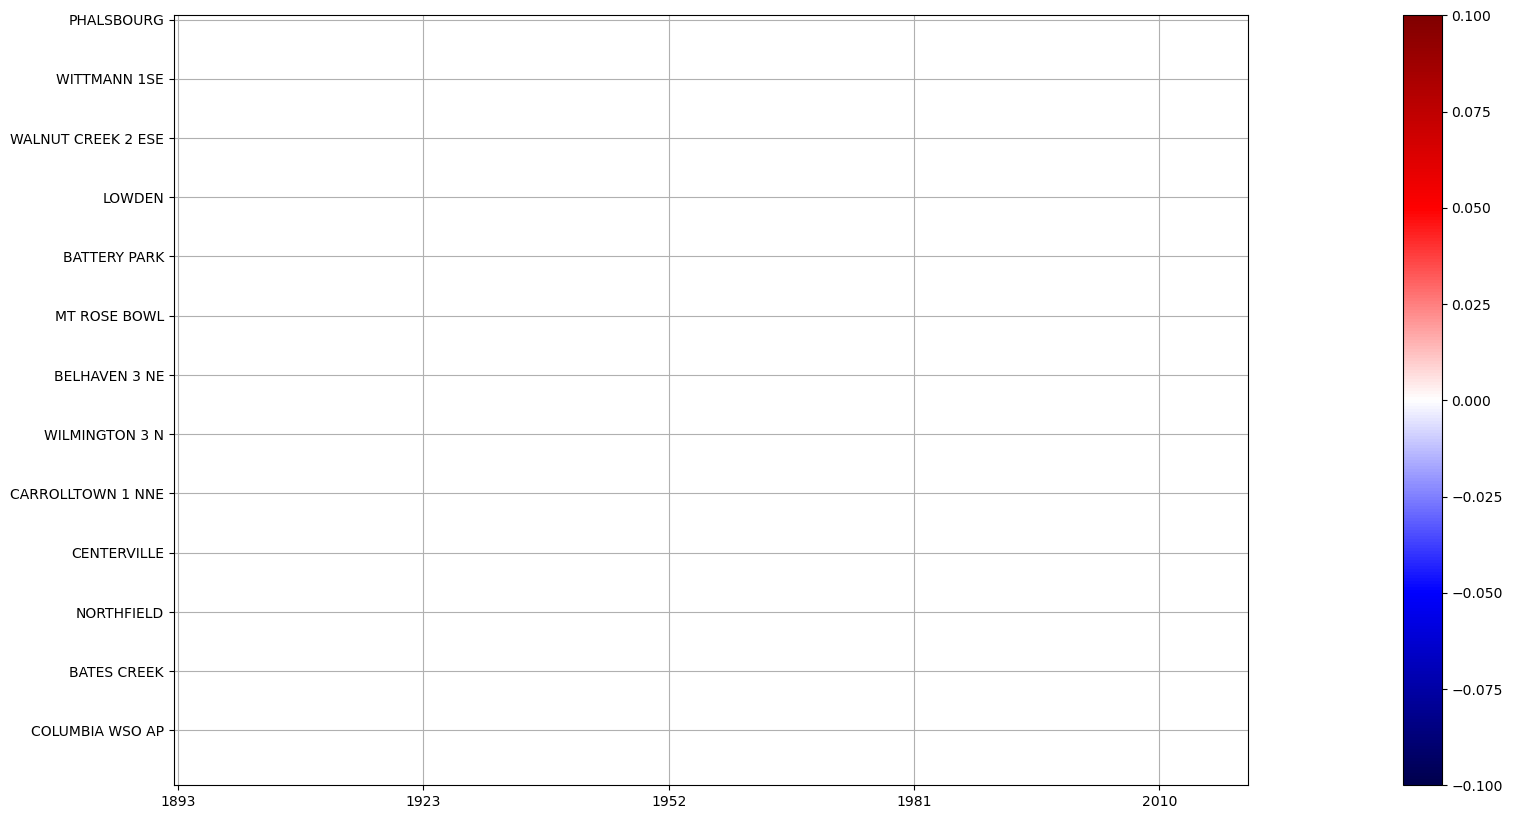

Heatmap for WT06 has shape (74, 97)


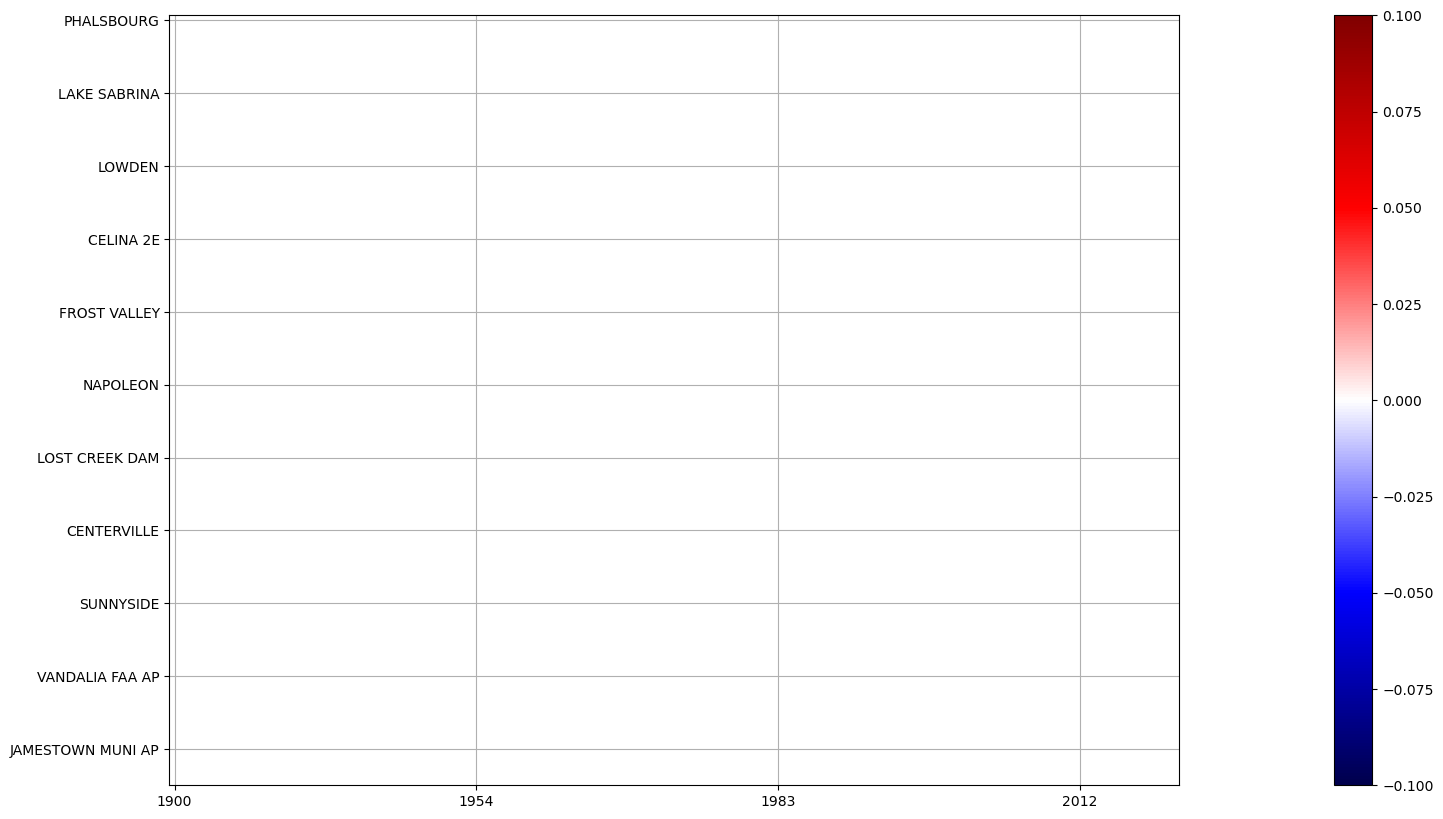

Heatmap for WT07 has shape (28, 74)


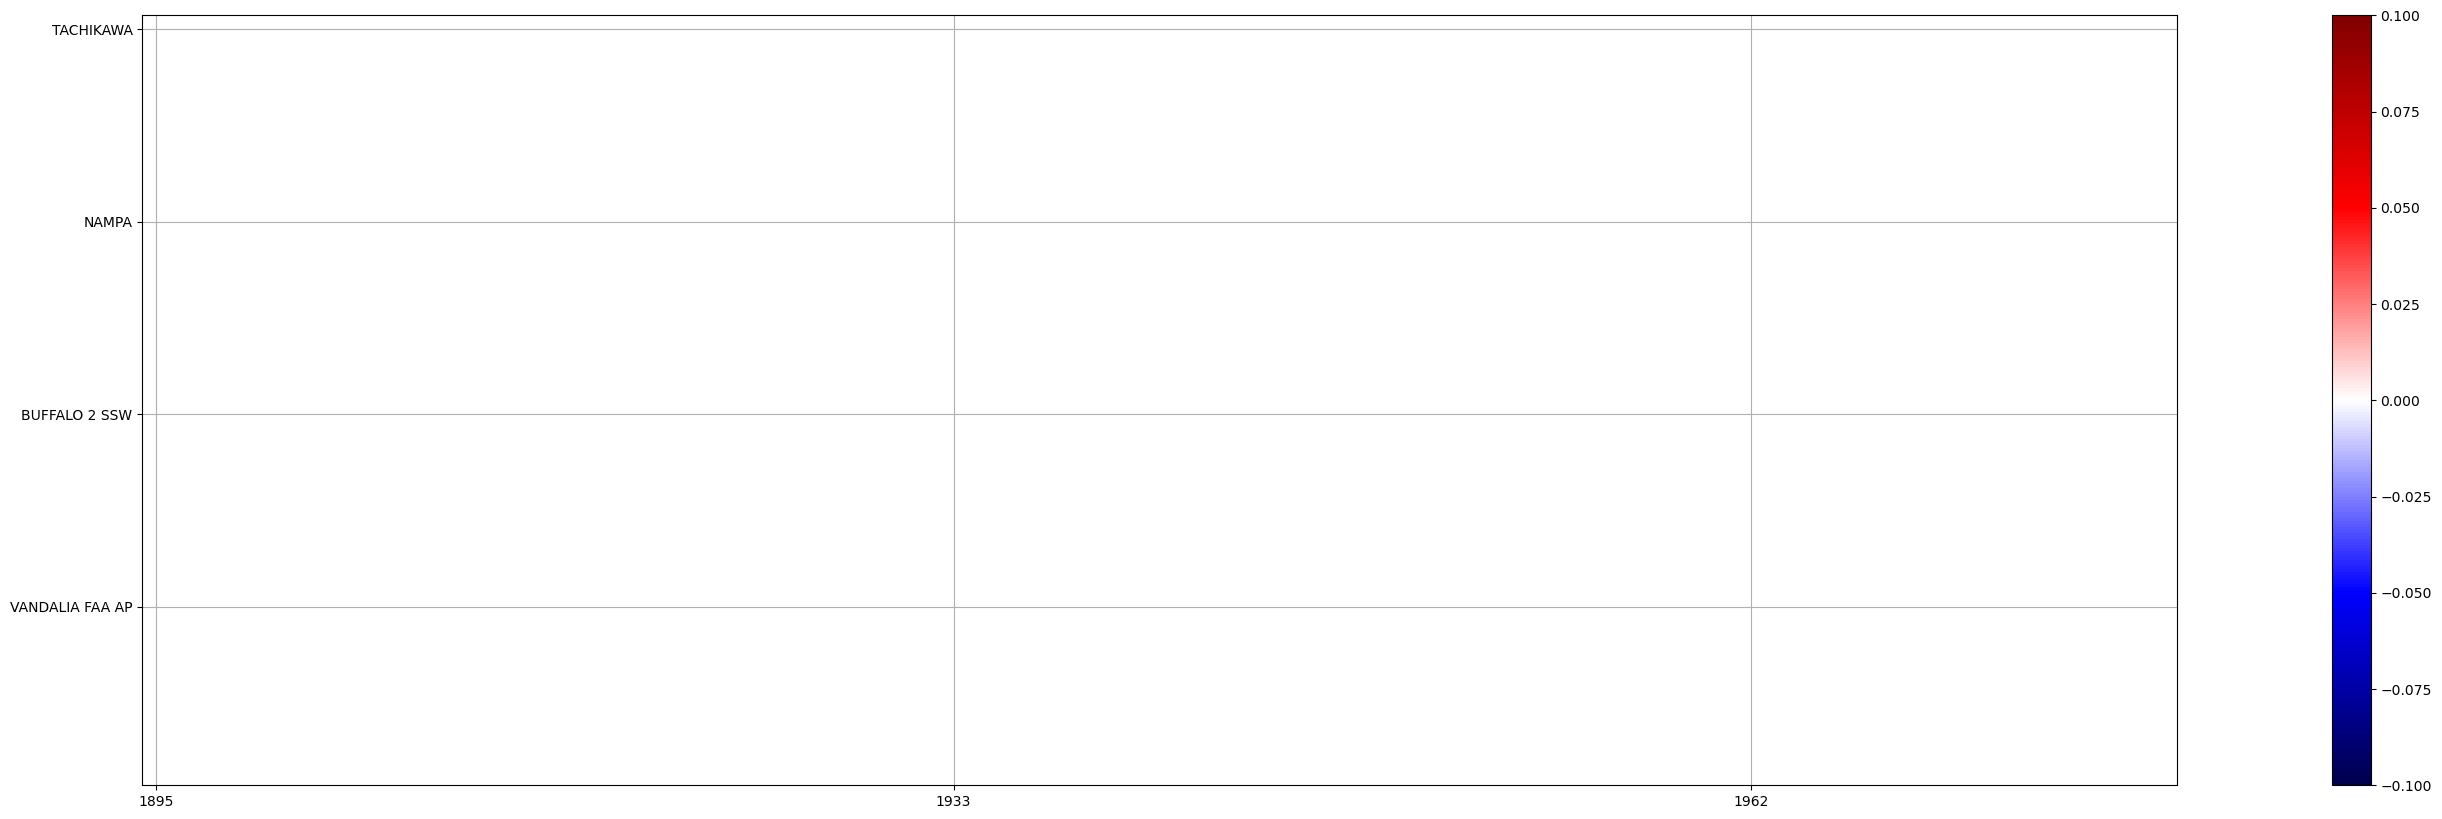

Heatmap for WT08 has shape (54, 119)


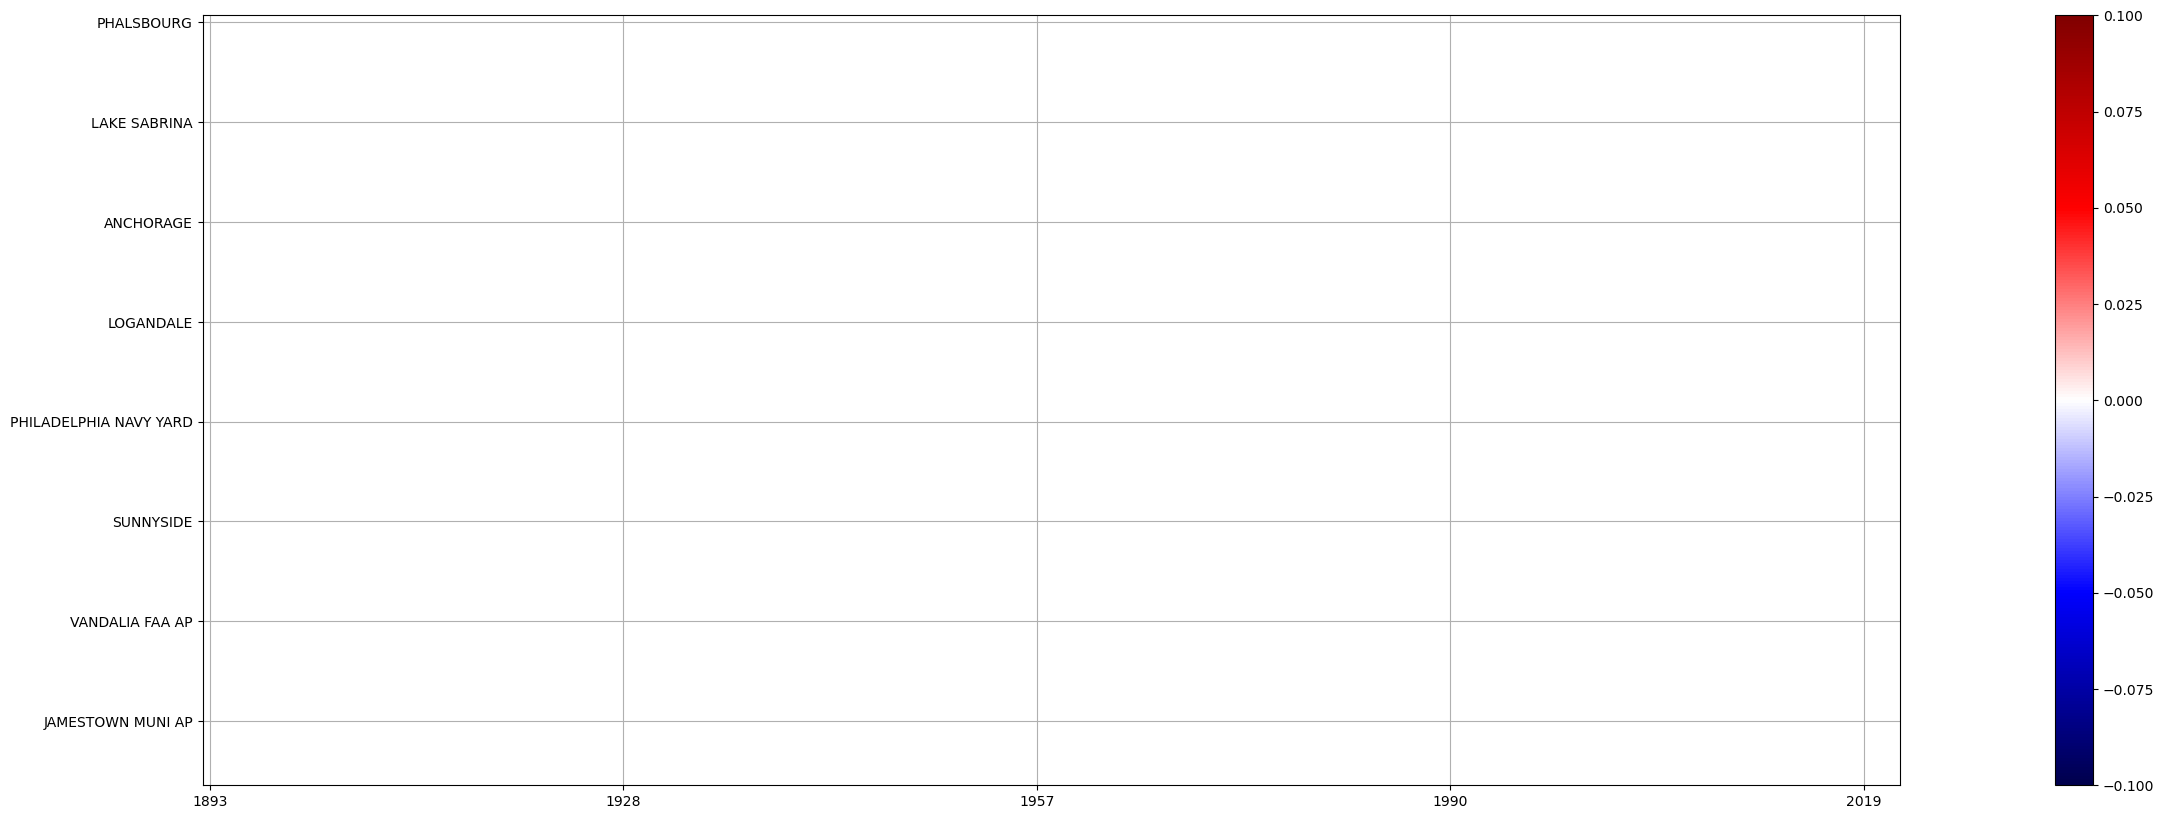

Heatmap for WT09 has shape (40, 101)


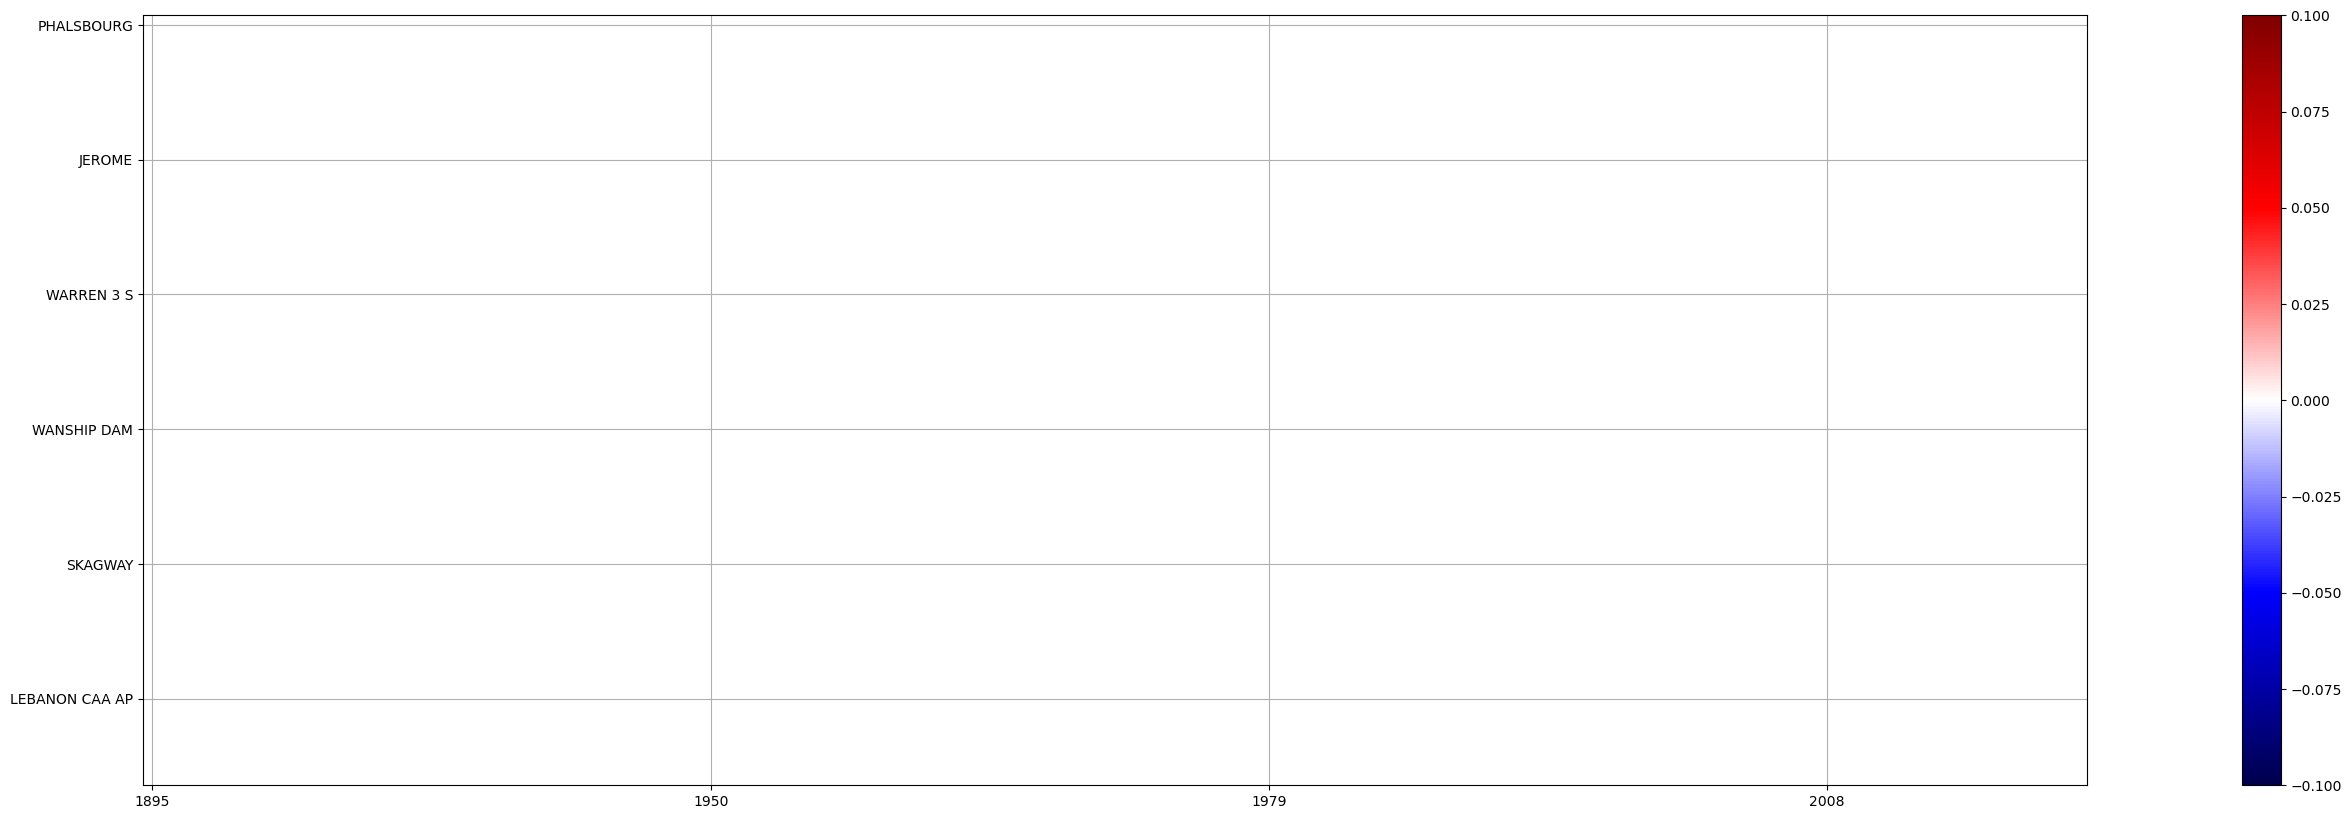

Heatmap for WT10 has shape (7, 7)


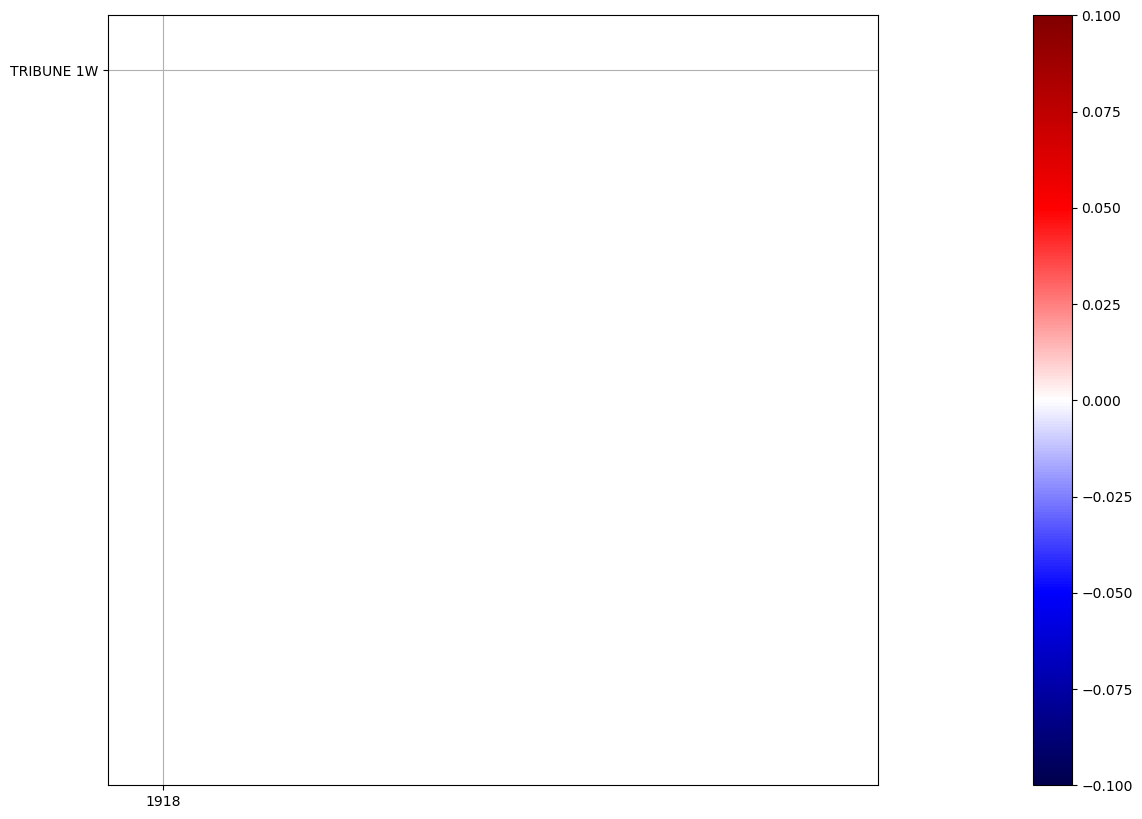

Heatmap for WT11 has shape (77, 112)


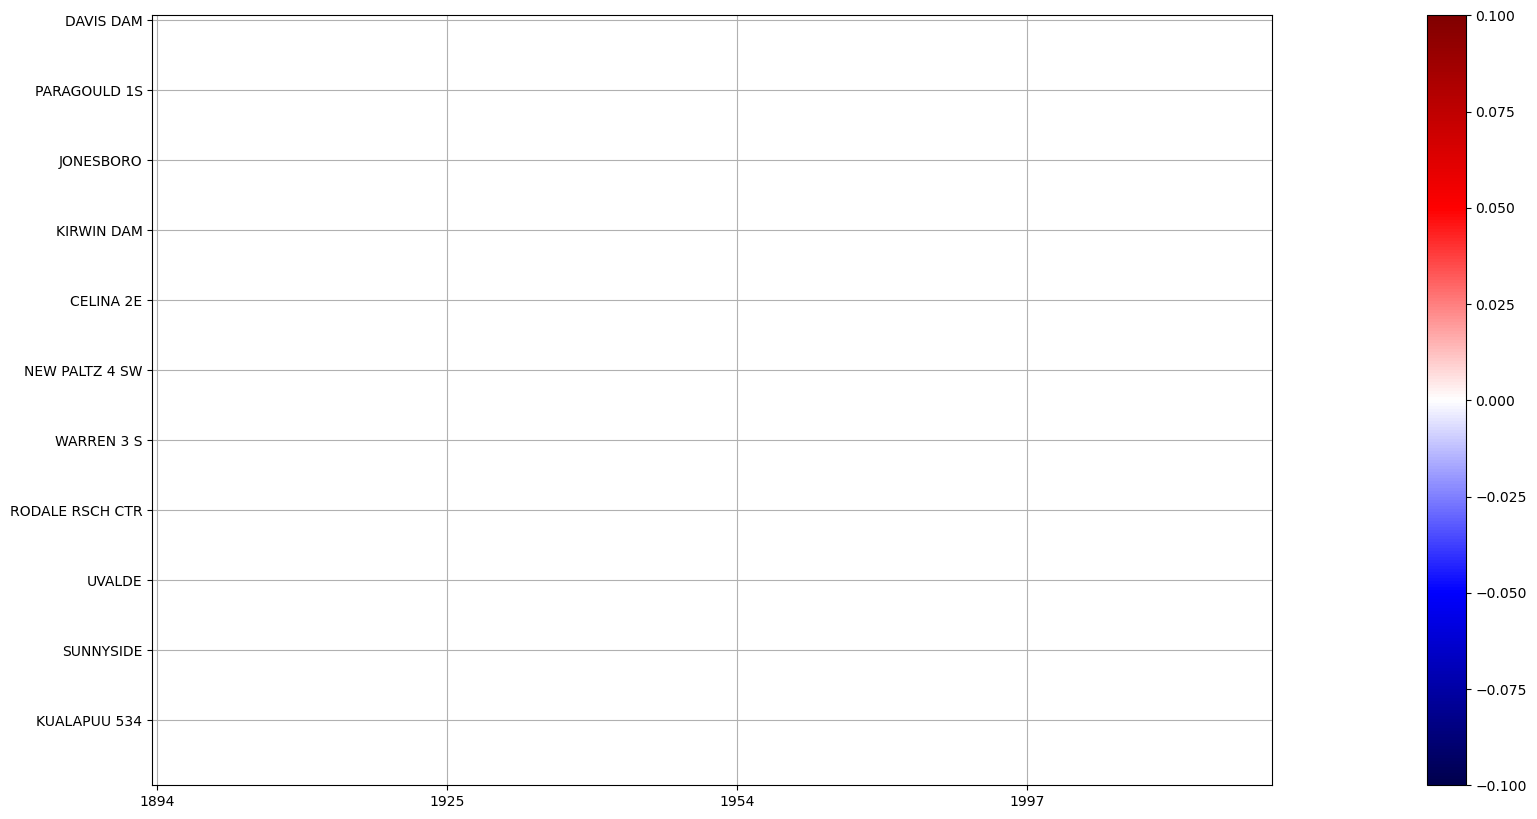

Heatmap for WT12 has shape (0, 0)


/tmp/ipykernel_17782/1579745309.py:8: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(array, cmap="seismic")
/tmp/ipykernel_17782/1579745309.py:8: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(array, cmap="seismic")


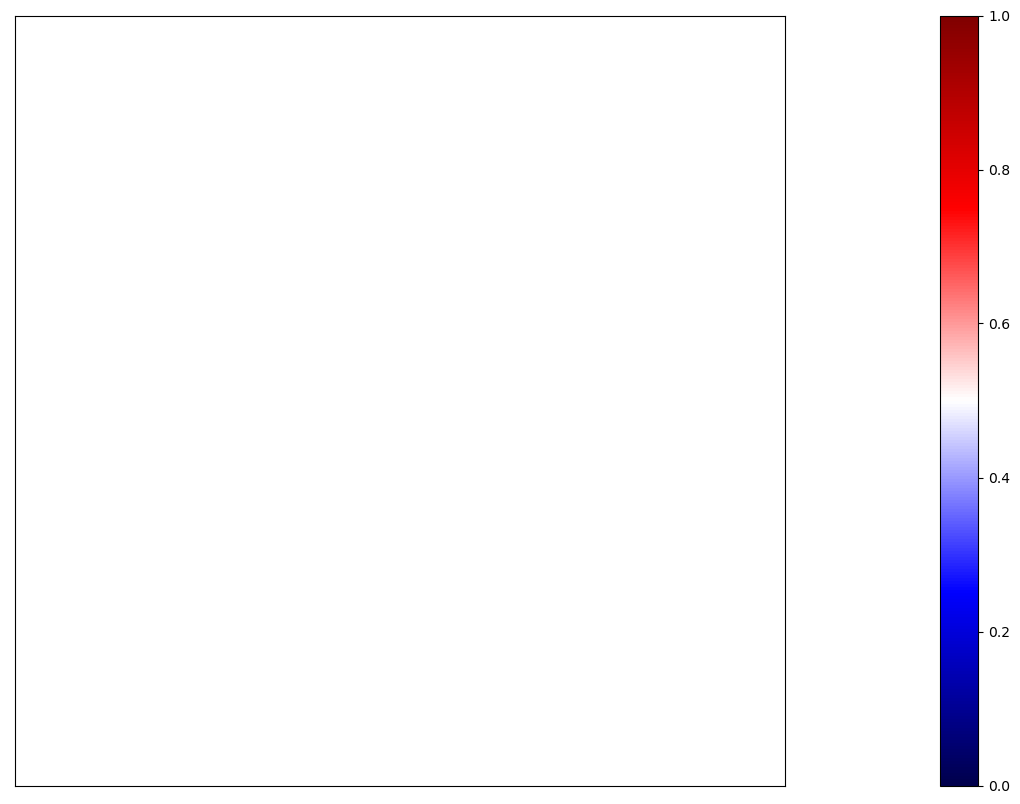

Heatmap for WT13 has shape (3, 18)


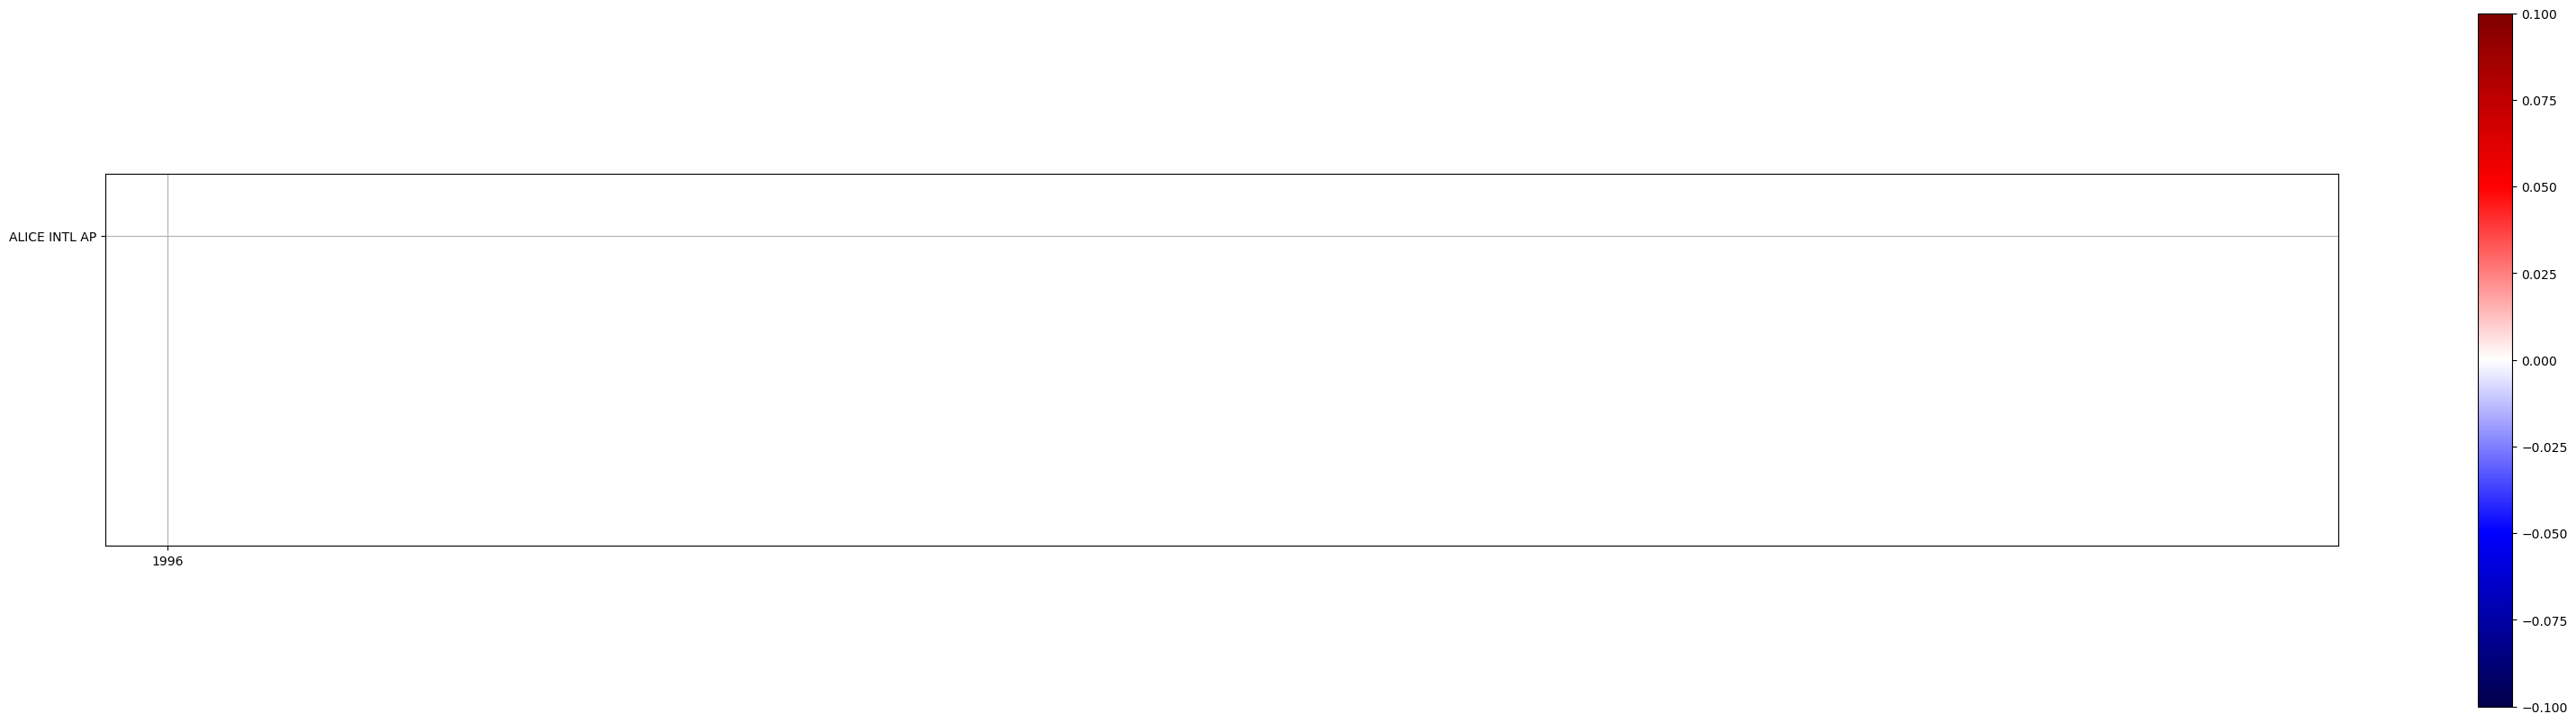

Heatmap for WT14 has shape (45, 101)


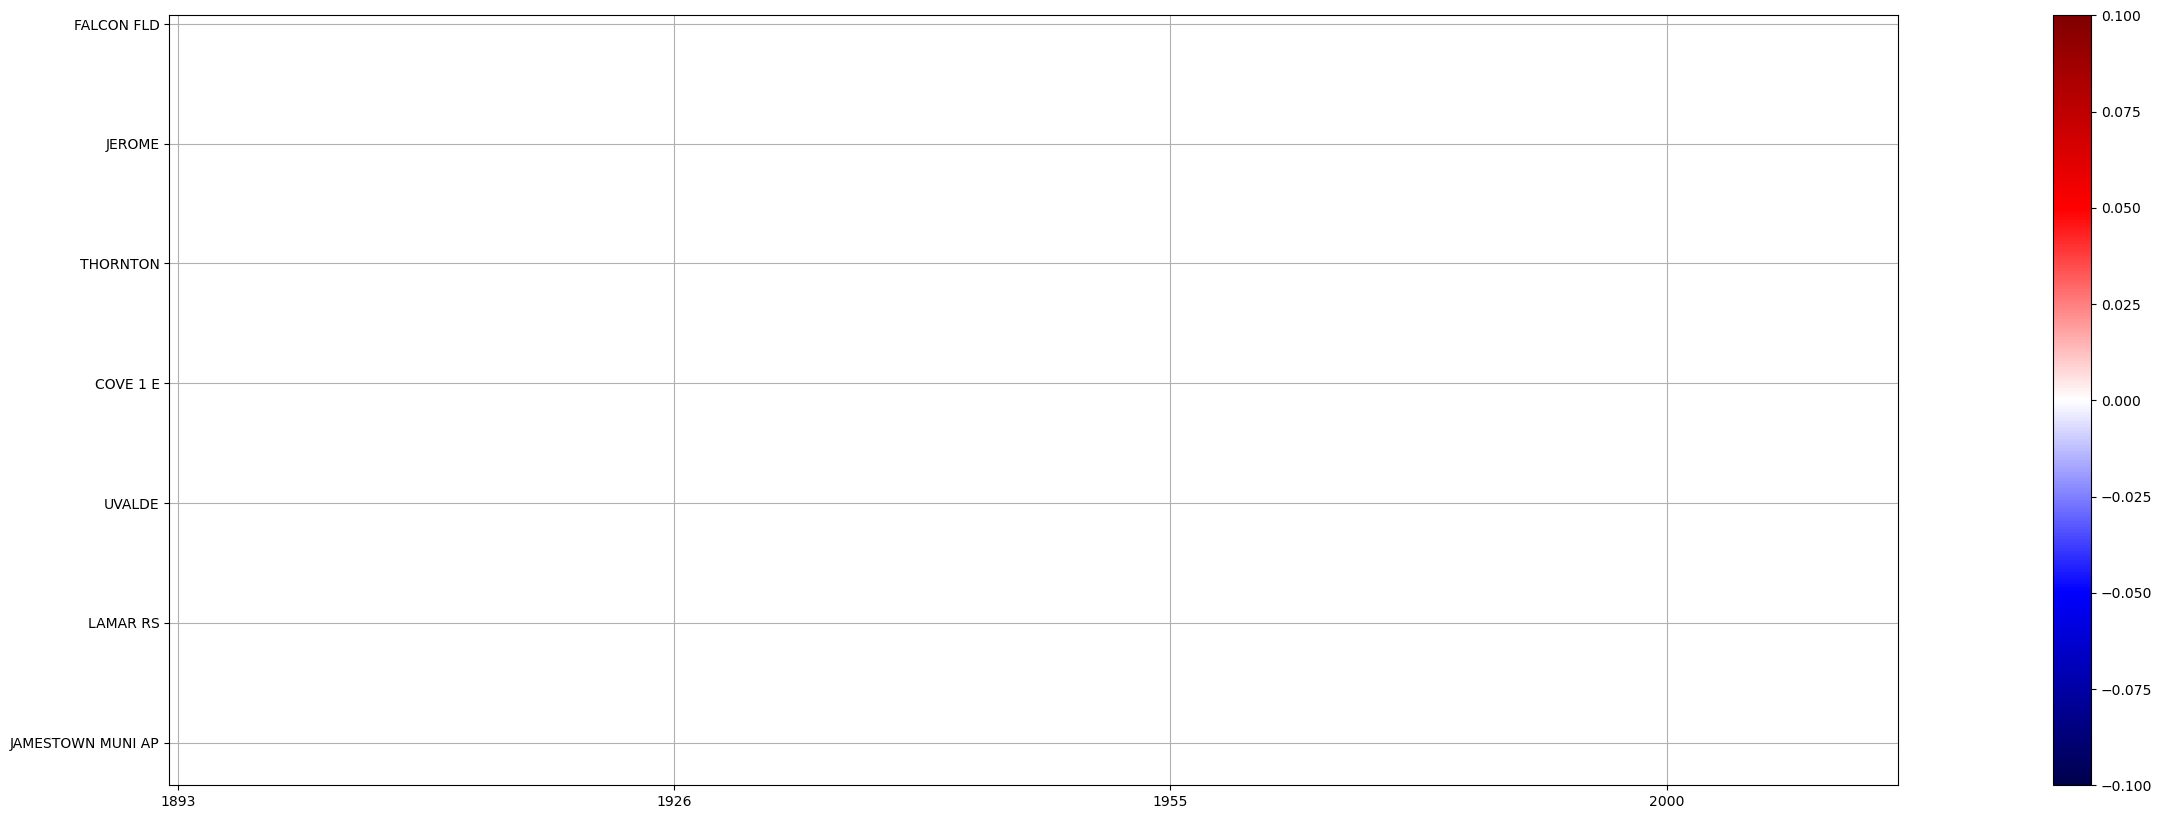

Heatmap for WT15 has shape (2, 22)


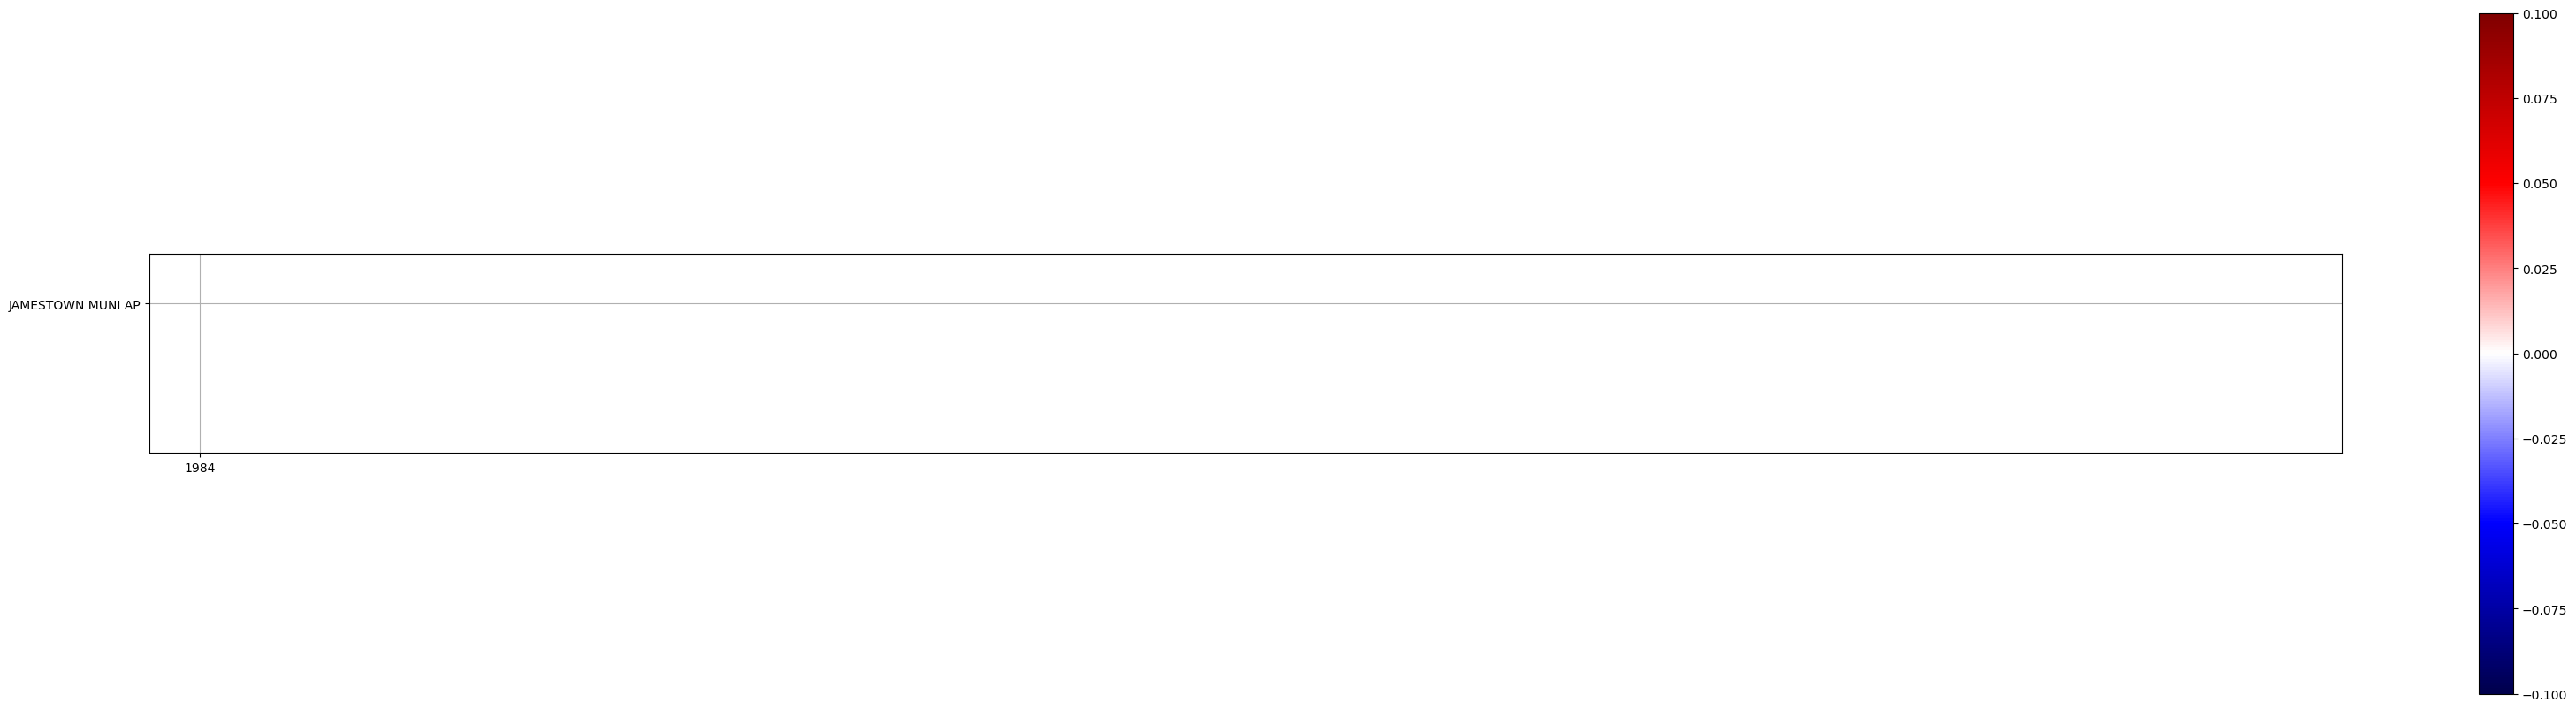

Heatmap for WT16 has shape (37, 113)


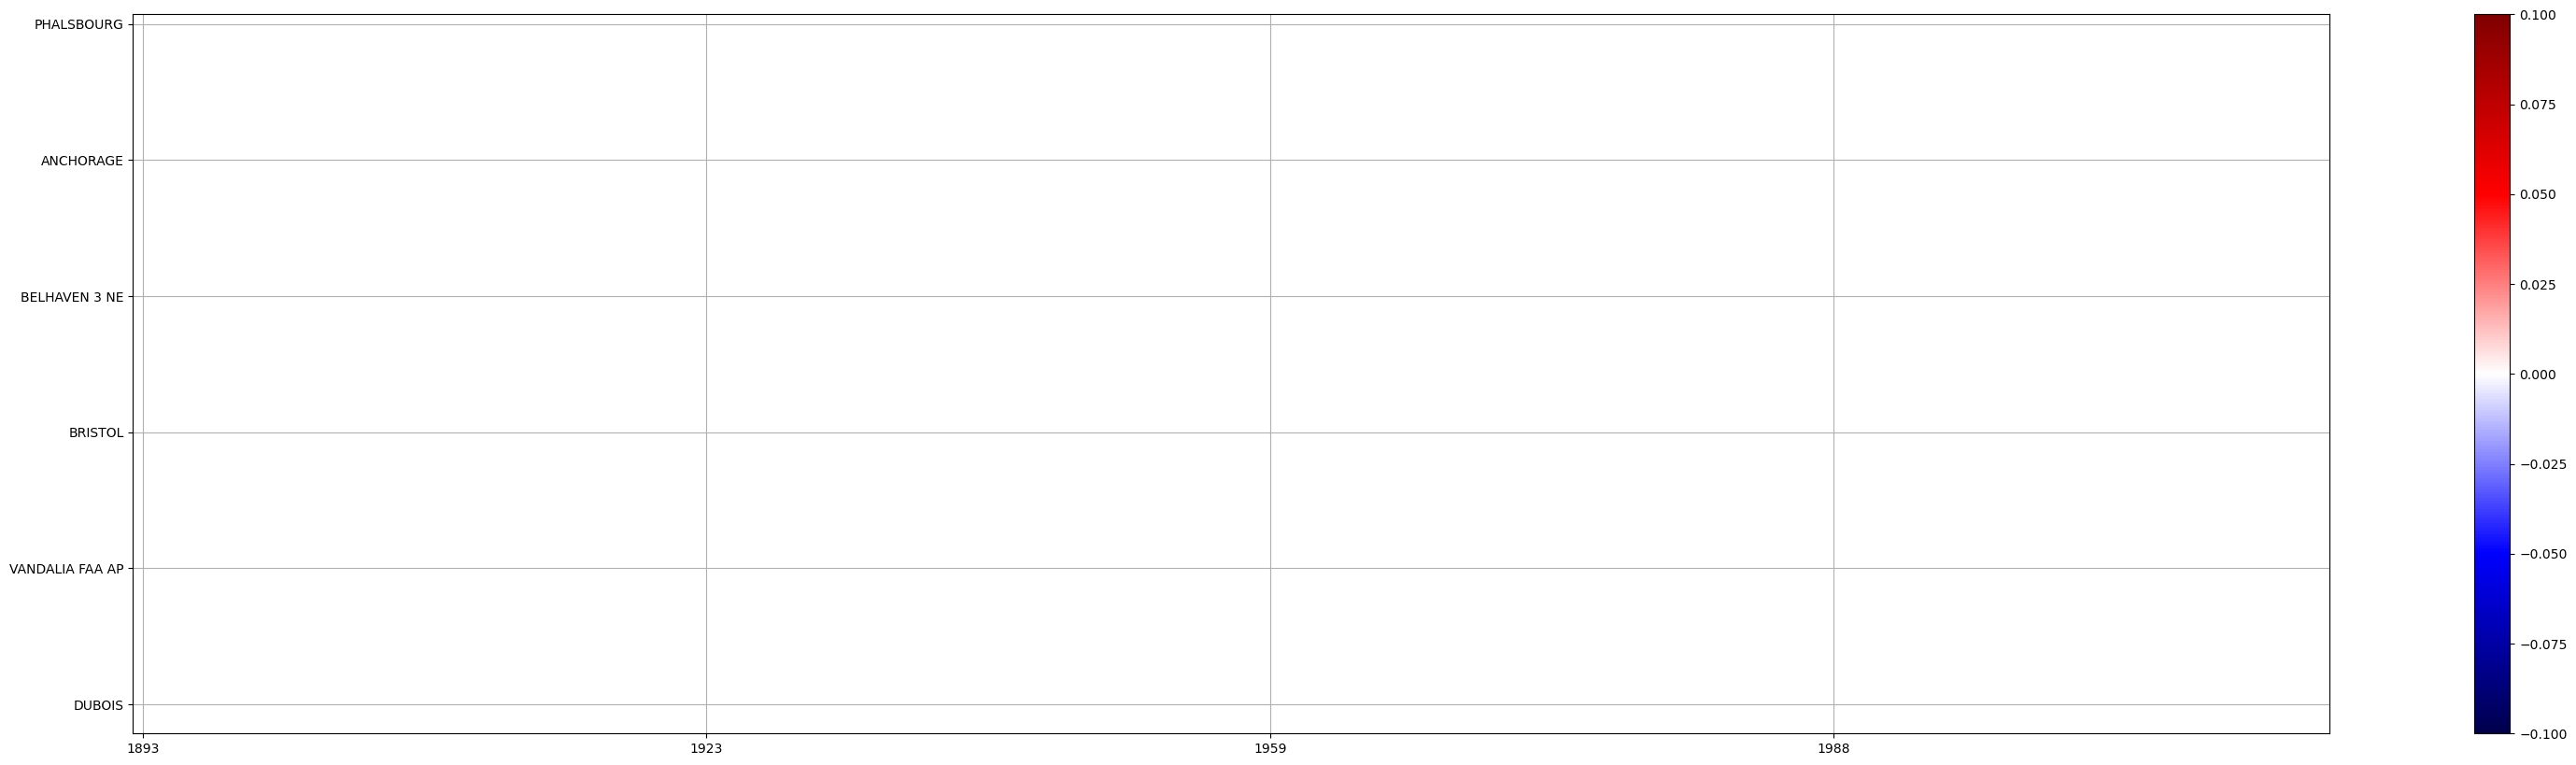

Heatmap for WT17 has shape (2, 26)


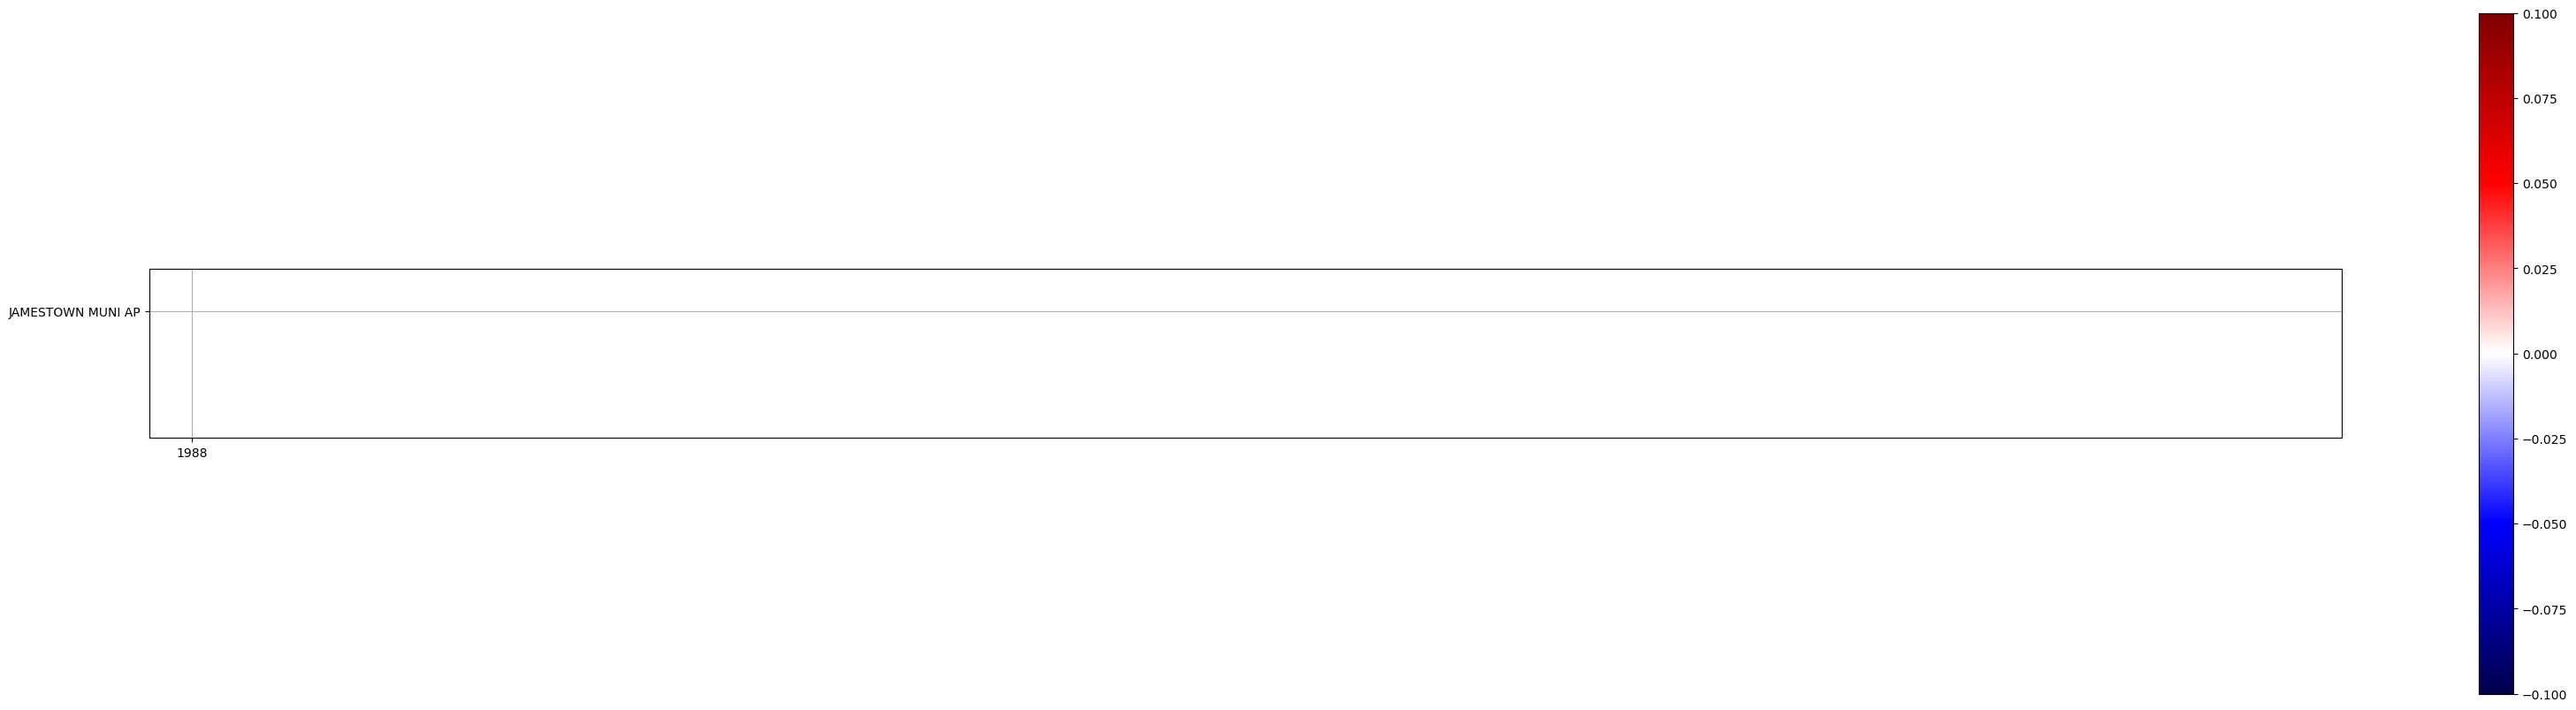

Heatmap for WT18 has shape (28, 111)


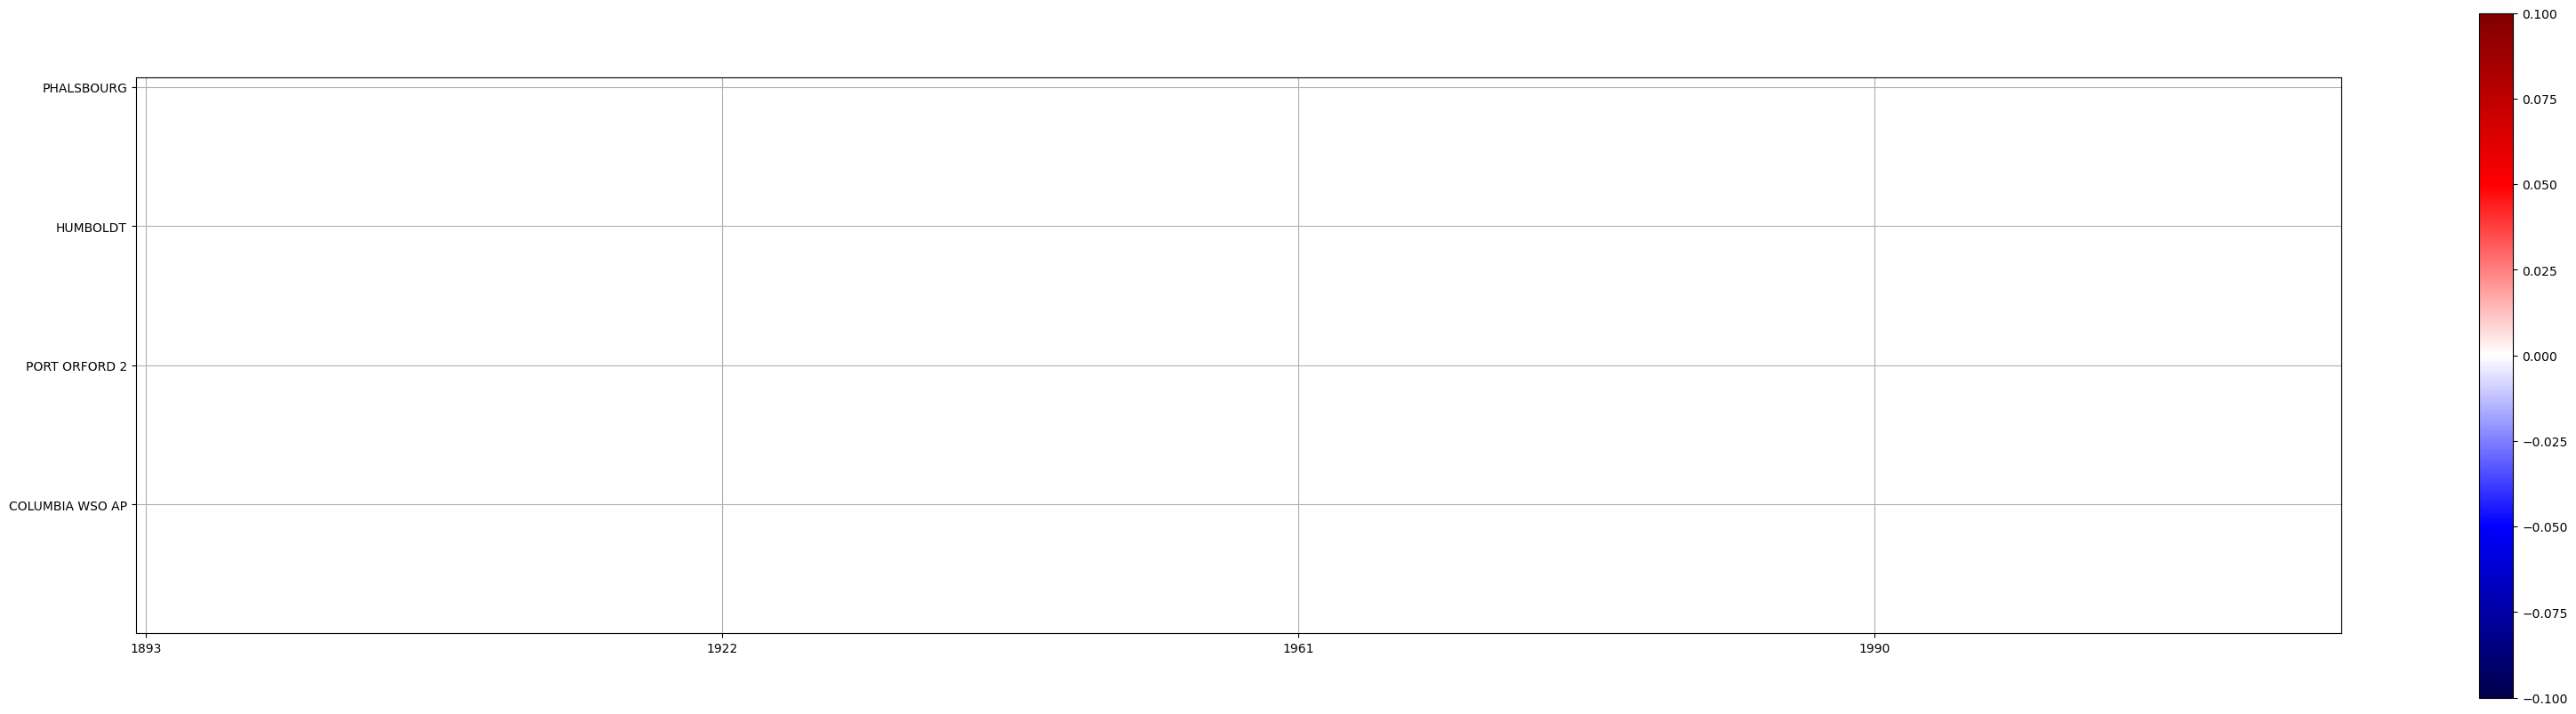

In [9]:
for i in range(len(metric_names)):
    plot_heatmap(metric_names[i])